In [7]:
# Import standard libraries
import datetime as dt  # Library for working with dates and times
from datetime import datetime, timedelta  # Import specific functionalities from datetime module for handling date and time

# Import third-party libraries
import pandas as pd  # Library for data manipulation and analysis
import numpy as np  # Library for numerical computations
import ta  # Technical Analysis library for financial markets - provides tools for technical analysis of financial markets

from scipy.optimize import minimize  # Optimization module in the SciPy package - provides functionality to minimize a function

import matplotlib.pyplot as plt  # Data visualization library - provides tools for making plots
import seaborn as sns  # Data visualization library based on Matplotlib - provides a high-level interface for drawing attractive and informative statistical graphics


In [8]:
# Load the combined DataFrame from the Excel file
excel_file_path = 'combined_data.xlsx'  # Specify the path to the Excel file

# Read the Excel file into a pandas DataFrame
# pd.read_excel() is a function that reads an Excel table into a pandas DataFrame
combined_data = pd.read_excel(excel_file_path)

# Display the first few rows of the combined DataFrame
# .head() is a function that returns the first n rows for the object based on position. It is useful for quickly testing if your object has the right type of data in it.
combined_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ATR,Returns,Volatility,...,SMA_50,EMA_50,Upper,Middle,Lower,RSI,MACD,MACD Signal,Beta,Ticker
0,2000-03-14,1.082310,1.109375,1.017857,1.020089,0.868217,428579200,0.065468,-0.058217,0.046187,...,0.988284,1.021796,1.162792,1.061251,0.959710,47.019852,0.025365,0.030936,1.40344,AAPL
1,2000-03-15,1.032366,1.073661,1.018973,1.037946,0.883415,443609600,0.064698,0.017505,0.044138,...,0.989054,1.022429,1.162067,1.060024,0.957980,49.006911,0.020576,0.028864,1.40344,AAPL
2,2000-03-16,1.047433,1.089286,1.022321,1.085379,0.923786,378100800,0.064860,0.045699,0.044855,...,0.992458,1.024898,1.164142,1.063344,0.962546,53.947810,0.020374,0.027166,1.40344,AAPL
3,2000-03-17,1.072545,1.116071,1.068080,1.116071,0.949909,305043200,0.063655,0.028278,0.044081,...,0.996208,1.028473,1.169603,1.067864,0.966125,56.860527,0.022432,0.026219,1.40344,AAPL
4,2000-03-20,1.102679,1.127232,1.092634,1.098214,0.934710,204489600,0.061579,-0.016000,0.044322,...,1.001208,1.031208,1.169614,1.073110,0.976605,54.693084,0.022364,0.025448,1.40344,AAPL


In [9]:
# RSI-based Trading Strategy
def rsi_based_trading_strategy(data, overbought_level=70, oversold_level=30):
    """
    This function applies a Relative Strength Index (RSI) based trading strategy on the provided data.
    
    Args:
        data (pd.DataFrame): A dataframe containing stock data which includes 'RSI' and 'Close' columns.
        overbought_level (int): The RSI level above which the asset is considered overbought.
        oversold_level (int): The RSI level below which the asset is considered oversold.
        
    Returns:
        list, list: Returns two lists representing the buy signals and sell signals, which are based on the closing price at the time of the signal.
    """
    buy_signals = []  # Initialize an empty list for buy signals
    sell_signals = []  # Initialize an empty list for sell signals
    in_position = False  # Initialize a flag for whether we're currently holding a position

    # Iterate over each row in the DataFrame. We use the itertuples() function as it's a fast form of iteration
    for i, row in enumerate(data.itertuples()):
        # Check if RSI is below the oversold level and we are not currently holding a position
        if row.RSI < oversold_level and not in_position:
            buy_signals.append(row.Close)  # Record the closing price as a buy signal
            sell_signals.append(None)  # No sell signal
            in_position = True  # We're now in a position after buying
        # Check if RSI is above the overbought level and we are currently holding a position
        elif row.RSI > overbought_level and in_position:
            sell_signals.append(row.Close)  # Record the closing price as a sell signal
            buy_signals.append(None)  # No buy signal
            in_position = False  # We're no longer in a position after selling
        else:
            # If neither condition is met, there's no action to be taken
            buy_signals.append(None)
            sell_signals.append(None)

    # Return the lists of buy and sell signals
    return buy_signals, sell_signals

In [10]:
# MACD and EMA Strategy
def macd_ema_strategy(data):
    """
    This function applies a trading strategy based on Moving Average Convergence Divergence (MACD) 
    and Exponential Moving Average (EMA) indicators to the provided data.
    
    Args:
        data (pd.DataFrame): A dataframe containing stock data which includes 'MACD', 'MACD Signal', 
                             'Close', 'EMA_20', 'EMA_50', and 'EMA_100' columns.
        
    Returns:
        list, list: Returns two lists representing the buy signals and sell signals, which are based on 
                    the closing price at the time of the signal.
    """
    buy_signals = []  # Initialize an empty list for buy signals
    sell_signals = []  # Initialize an empty list for sell signals
    position = False  # Initialize a flag for whether we're currently holding a position

    # Iterate over each row in the DataFrame
    for i in range(len(data)):
        # Buy condition: MACD is above MACD Signal, closing price is above 20-Day EMA, and closing price is above 50-Day EMA
        if (data.iloc[i]['MACD'] > data.iloc[i]['MACD Signal'] and 
            data.iloc[i]['Close'] > data.iloc[i]['EMA_20'] and 
            data.iloc[i]['Close'] > data.iloc[i]['EMA_50'] and 
            not position):
            
            buy_signals.append(data.iloc[i]['Close'])  # Record the closing price as a buy signal
            sell_signals.append(None)  # No sell signal
            position = True  # We're now in a position after buying
        # Sell condition: MACD is below MACD Signal and closing price is below 100-Day EMA
        elif (data.iloc[i]['MACD'] < data.iloc[i]['MACD Signal'] and 
              data.iloc[i]['Close'] < data.iloc[i]['EMA_100'] and 
              position):
            
            sell_signals.append(data.iloc[i]['Close'])  # Record the closing price as a sell signal
            buy_signals.append(None)  # No buy signal
            position = False  # We're no longer in a position after selling
        else:
            # If neither condition is met, there's no action to be taken
            buy_signals.append(None)
            sell_signals.append(None)

    # Return the lists of buy and sell signals
    return buy_signals, sell_signals

In [11]:
# Apply the RSI-based and MACD-EMA trading strategies to combined_data
# Define a list of stock tickers to analyze
stock_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'SPY', 'QQQ']

# Loop over each ticker in the list
for ticker in stock_tickers:
    # Filter the combined_data DataFrame to include only data for the current ticker
    ticker_data = combined_data[combined_data['Ticker'] == ticker].copy()
    
    # Apply the RSI-based trading strategy to the ticker data
    # This will add 'Buy Signals RSI' and 'Sell Signals RSI' columns to the ticker_data DataFrame
    ticker_data['Buy Signals RSI'], ticker_data['Sell Signals RSI'] = rsi_based_trading_strategy(ticker_data)
    
    # Calculate EMA indicators for the ticker data
    # This will add 'EMA_20', 'EMA_50', and 'EMA_100' columns to the ticker_data DataFrame
    ticker_data['EMA_20'] = ticker_data['Close'].ewm(span=20).mean()  # 20-day EMA
    ticker_data['EMA_50'] = ticker_data['Close'].ewm(span=50).mean()  # 50-day EMA
    ticker_data['EMA_100'] = ticker_data['Close'].ewm(span=100).mean()  # 100-day EMA
    
    # Apply the MACD and EMA strategy to the ticker data
    # This will add 'Buy Signals MACD_EMA' and 'Sell Signals MACD_EMA' columns to the ticker_data DataFrame
    ticker_data['Buy Signals MACD_EMA'], ticker_data['Sell Signals MACD_EMA'] = macd_ema_strategy(ticker_data)

In [12]:
# Function to calculate the performance of a trading strategy
def strategy_performance(data, buy_col, sell_col):
    """
    This function calculates the performance metrics of a trading strategy.
    It takes a DataFrame with historical prices and buy/sell signals, and returns a dictionary with performance metrics.
    """

    # Extract buy and sell signals, dropping missing values
    buy_signals = data[buy_col].dropna()
    sell_signals = data[sell_col].dropna()

    # If there are no buy or sell signals, return a dictionary with zero metrics
    if buy_signals.empty or sell_signals.empty:
        return {
            "Total Return": 0,
            "Average Return": 0,
            "Sharpe Ratio": 0,
            "Max Drawdown": 0,
        }

    # Ensure that trading starts with a buy and ends with a sell
    if buy_signals.index[0] > sell_signals.index[0]:
        sell_signals = sell_signals.iloc[1:]
    if buy_signals.index[-1] > sell_signals.index[-1]:
        buy_signals = buy_signals.iloc[:-1]

    # Calculate returns, total return, and average return
    returns = (sell_signals.values / buy_signals.values) - 1
    total_return = np.prod(1 + returns) - 1
    average_return = np.mean(returns)

    # Calculate the Sharpe Ratio using daily returns
    daily_returns = data['Close'].pct_change().mask(data[buy_col].isna()).dropna()
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

    # Calculate the Max Drawdown
    max_drawdown = np.min(np.divide(sell_signals.values, buy_signals.values)) - 1

    # Return a dictionary with the calculated metrics
    return {
        'Total Return': total_return,
        'Average Return': average_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Add Exponential Moving Average (EMA) features to the combined_data DataFrame
combined_data['EMA_100'] = combined_data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=100).mean())
combined_data['EMA_20'] = combined_data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=20).mean())

# Define the list of stock tickers to be processed
stock_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'SPY', 'QQQ']

# Initialize a dictionary to store performance metrics for each ticker and strategy
performance_metrics = {}

# Loop over each ticker
for ticker in stock_tickers:
    # Copy the data for the current ticker
    ticker_data = combined_data[combined_data['Ticker'] == ticker].copy()

    # Apply the RSI and MACD-EMA trading strategies to the ticker data
    ticker_data['Buy Signals RSI'], ticker_data['Sell Signals RSI'] = rsi_based_trading_strategy(ticker_data)
    ticker_data['Buy Signals MACD_EMA'], ticker_data['Sell Signals MACD_EMA'] = macd_ema_strategy(ticker_data)

    # Initialize a nested dictionary to store performance metrics for each strategy
    performance_metrics[ticker] = {}

    # Calculate and store performance metrics for the RSI-based strategy
    rsi_strategy_performance = strategy_performance(ticker_data, 'Buy Signals RSI', 'Sell Signals RSI')
    performance_metrics[ticker]['RSI'] = rsi_strategy_performance

    # Calculate and store performance metrics for the RSI-based strategy
    rsi_strategy_performance = strategy_performance(ticker_data, 'Buy Signals RSI', 'Sell Signals RSI')
    performance_metrics[ticker]['RSI'] = rsi_strategy_performance

    # Calculate and store performance metrics for the MACD and EMA strategy
    macd_ema_strategy_performance = strategy_performance(ticker_data, 'Buy Signals MACD_EMA', 'Sell Signals MACD_EMA')
    performance_metrics[ticker]['MACD_EMA'] = macd_ema_strategy_performance

# Loop over each ticker and strategy in the performance metrics dictionary
for ticker, strategies in performance_metrics.items():
    # Print the ticker and some separation for readability
    print(f"\n{'-' * 30}\n{ticker} Performance Metrics\n{'-' * 30}")
    
    # Loop over each strategy and its metrics
    for strategy, metrics in strategies.items():
        # Print the strategy name
        print(f"\n{strategy} Strategy Performance:")
        # Print the performance metrics for the current strategy
        print(metrics)


------------------------------
AAPL Performance Metrics
------------------------------

RSI Strategy Performance:
{'Total Return': 0.7850388763075526, 'Average Return': 0.0518482354511657, 'Sharpe Ratio': -9.309567293944315, 'Max Drawdown': -0.29021624087237874}

MACD_EMA Strategy Performance:
{'Total Return': 262.4240529151233, 'Average Return': 0.11329241203003387, 'Sharpe Ratio': 17.2385637379386, 'Max Drawdown': -0.14655172059425414}

------------------------------
MSFT Performance Metrics
------------------------------

RSI Strategy Performance:
{'Total Return': 3.314405407711921, 'Average Return': 0.08004095502682944, 'Sharpe Ratio': -17.84128522947799, 'Max Drawdown': -0.12247325440553691}

MACD_EMA Strategy Performance:
{'Total Return': 1.7372079301582999, 'Average Return': 0.01604817091453056, 'Sharpe Ratio': 17.595294777241314, 'Max Drawdown': -0.11557177615571779}

------------------------------
AMZN Performance Metrics
------------------------------

RSI Strategy Performan

In [13]:
def rsi_based_trading_strategy_custom(data, overbought_level, oversold_level):
    """
    This function implements a simple Relative Strength Index (RSI) based trading strategy.
    When the RSI is below the oversold level, it sends a buy signal. When the RSI is above the overbought level, it sends a sell signal.

    Args:
        data (pd.DataFrame): A DataFrame containing the historical price data and RSI.
        overbought_level (int): The RSI level above which the asset is considered overbought.
        oversold_level (int): The RSI level below which the asset is considered oversold.

    Returns:
        list, list: Lists of the buy signals and sell signals.
    """
    # Initialize empty lists to store the buy and sell signals
    buy_signals = []
    sell_signals = []
    
    # Initialize a flag to indicate whether we're currently in a position
    in_position = False

    # Loop over the DataFrame row by row
    for index, row in data.iterrows():
        # If the RSI is below the oversold level and we're not already in a position, send a buy signal
        if row['RSI'] <= oversold_level and not in_position:
            buy_signals.append(row['Close'])
            sell_signals.append(np.nan)
            in_position = True  # Update the position flag
        # If the RSI is above the overbought level and we're currently in a position, send a sell signal
        elif row['RSI'] >= overbought_level and in_position:
            sell_signals.append(row['Close'])
            buy_signals.append(np.nan)
            in_position = False  # Update the position flag
        # If neither condition is met, append NaN to both signal lists
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    # Return the lists of buy and sell signals
    return buy_signals, sell_signals

In [14]:
def macd_ema_strategy_custom(data, short_ema_span, long_ema_span):
    """
    This function implements a trading strategy based on the Moving Average Convergence Divergence (MACD) and Exponential Moving Averages (EMA).
    It sends a buy signal when the MACD line crosses above the signal line and a sell signal when the MACD line crosses below the signal line.

    Args:
        data (pd.DataFrame): A DataFrame containing the historical price data.
        short_ema_span (int): The span of the short-term EMA.
        long_ema_span (int): The span of the long-term EMA.

    Returns:
        list, list: Lists of the buy signals and sell signals.
    """
    # Calculate the short-term EMA
    data['EMA_Short'] = data['Close'].ewm(span=short_ema_span, adjust=False).mean()
    
    # Calculate the long-term EMA
    data['EMA_Long'] = data['Close'].ewm(span=long_ema_span, adjust=False).mean()
    
    # Calculate the MACD line as the difference between the short-term EMA and the long-term EMA
    data['MACD'] = data['EMA_Short'] - data['EMA_Long']
    
    # Calculate the signal line as the 9-period EMA of the MACD line
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    
    # Initialize empty lists to store the buy and sell signals
    buy_signals = []
    sell_signals = []
    
    # Initialize a flag to indicate whether we're currently in a position
    in_position = False

    # Loop over the DataFrame row by row
    for index, row in data.iterrows():
        # If the MACD line crosses above the signal line and we're not already in a position, send a buy signal
        if row['MACD'] > row['MACD_Signal'] and not in_position:
            buy_signals.append(row['Close'])
            sell_signals.append(np.nan)
            in_position = True  # Update the position flag
        # If the MACD line crosses below the signal line and we're currently in a position, send a sell signal
        elif row['MACD'] < row['MACD_Signal'] and in_position:
            sell_signals.append(row['Close'])
            buy_signals.append(np.nan)
            in_position = False  # Update the position flag
        # If neither condition is met, append NaN to both signal lists
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    # Return the lists of buy and sell signals
    return buy_signals, sell_signals

In [20]:
# Optimization of RSI and MACD-EMA Strategy Parameters

import itertools

# Define the parameter search space for RSI
overbought_levels = range(65, 81, 5)
oversold_levels = range(15, 36, 5)
rsi_param_space = list(itertools.product(overbought_levels, oversold_levels))

best_rsi_performance = None
best_rsi_params = None

# Search for the best RSI parameters
for overbought_level, oversold_level in rsi_param_space:
    performance = 0
    for ticker in stock_tickers:
        # Copy the data for the current ticker
        ticker_data = combined_data[combined_data['Ticker'] == ticker].copy()

        # Apply the RSI strategy to the ticker data with the current parameter combination
        ticker_data['Buy Signals RSI'], ticker_data['Sell Signals RSI'] = rsi_based_trading_strategy_custom(ticker_data, overbought_level, oversold_level)

        # Calculate the performance of the RSI strategy with the current parameter combination
        rsi_strategy_performance = strategy_performance(ticker_data, 'Buy Signals RSI', 'Sell Signals RSI')

        # Update the total performance across all tickers with the current parameter combination
        performance += rsi_strategy_performance['Total Return']

    # Update the best RSI parameters and their performance if the current parameter combination is better
    if best_rsi_performance is None or performance > best_rsi_performance:
        best_rsi_performance = performance
        best_rsi_params = (overbought_level, oversold_level)

# Print the best RSI parameters
print("Best RSI parameters:", best_rsi_params)

# Define the parameter search space for MACD-EMA
short_ema_spans = range(10, 31, 5)
long_ema_spans = range(40, 101, 20)
ema_spans = list(itertools.product(short_ema_spans, long_ema_spans))

best_macd_ema_performance = None
best_macd_ema_params = None

# Search for the best MACD-EMA parameters
for short_ema_span, long_ema_span in ema_spans:
    performance = 0
    for ticker in stock_tickers:
        # Copy the data for the current ticker
        ticker_data = combined_data[combined_data['Ticker'] == ticker].copy()

        # Apply the MACD-EMA strategy to the ticker data with the current parameter combination
        ticker_data['Buy Signals MACD_EMA'], ticker_data['Sell Signals MACD_EMA'] = macd_ema_strategy_custom(ticker_data, short_ema_span, long_ema_span)

        # Calculate the performance of the MACD-EMA strategy with the current parameter combination
        macd_ema_strategy_performance = strategy_performance(ticker_data, 'Buy Signals MACD_EMA', 'Sell Signals MACD_EMA')

        # Update the total performance across all tickers with the current parameter combination
        performance += macd_ema_strategy_performance['Total Return']

    # Update the best MACD-EMA parameters and their performance if the current parameter combination is better
    if best_macd_ema_performance is None or performance > best_macd_ema_performance:
        best_macd_ema_performance = performance
        best_macd_ema_params = (short_ema_span, long_ema_span)

# Print the best MACD-EMA parameters
print("Best MACD-EMA parameters:", best_macd_ema_params)

# Initialize a dictionary to store the performance metrics for the optimized strategies
optimized_performance_metrics = {}

# Loop over each ticker
for ticker in stock_tickers:
    # Copy the data for the current ticker
    ticker_data = combined_data[combined_data['Ticker'] == ticker].copy()
    
    # Use the best RSI parameters
    overbought_level, oversold_level = best_rsi_params
    ticker_data['Buy Signals RSI'], ticker_data['Sell Signals RSI'] = rsi_based_trading_strategy_custom(ticker_data, overbought_level, oversold_level)
    
    # Calculate and store the performance metrics for the RSI strategy using the best parameters
    rsi_strategy_performance = strategy_performance(ticker_data, 'Buy Signals RSI', 'Sell Signals RSI')
    
    # Use the best MACD-EMA parameters
    short_ema_span, long_ema_span = best_macd_ema_params
    ticker_data['Buy Signals MACD_EMA'], ticker_data['Sell Signals MACD_EMA'] = macd_ema_strategy_custom(ticker_data, short_ema_span, long_ema_span)
    
    # Calculate and store the performance metrics for the MACD-EMA strategy using the best parameters
    macd_ema_strategy_performance = strategy_performance(ticker_data, 'Buy Signals MACD_EMA', 'Sell Signals MACD_EMA')

    # Store the performance metrics for the optimized strategies for the current ticker
    optimized_performance_metrics[ticker] = {
        'RSI': rsi_strategy_performance,
        'MACD_EMA': macd_ema_strategy_performance
    }

# Print the optimized performance metrics
for ticker, strategies in optimized_performance_metrics.items():
    print(f"\n{'-' * 30}\n{ticker} Optimized Performance Metrics\n{'-' * 30}")

    for strategy, metrics in strategies.items():
        print(f"\n{strategy} Strategy Optimized Performance:")
        print(metrics)

Best RSI parameters: (80, 35)
Best MACD-EMA parameters: (15, 100)

------------------------------
AAPL Optimized Performance Metrics
------------------------------

RSI Strategy Optimized Performance:
{'Total Return': 24.495568424369004, 'Average Return': 0.3204368823332134, 'Sharpe Ratio': -23.283484892480203, 'Max Drawdown': -0.6475771872695217}

MACD_EMA Strategy Optimized Performance:
{'Total Return': 46.71988526663575, 'Average Return': 0.03119444427317425, 'Sharpe Ratio': 14.173044996961112, 'Max Drawdown': -0.1426232626847721}

------------------------------
MSFT Optimized Performance Metrics
------------------------------

RSI Strategy Optimized Performance:
{'Total Return': 1.841315237606591, 'Average Return': 0.21618682509688228, 'Sharpe Ratio': -22.747111233969637, 'Max Drawdown': -0.29524411178949317}

MACD_EMA Strategy Optimized Performance:
{'Total Return': 0.38968479037192716, 'Average Return': 0.004523283568187916, 'Sharpe Ratio': 13.471952750857987, 'Max Drawdown': -0.

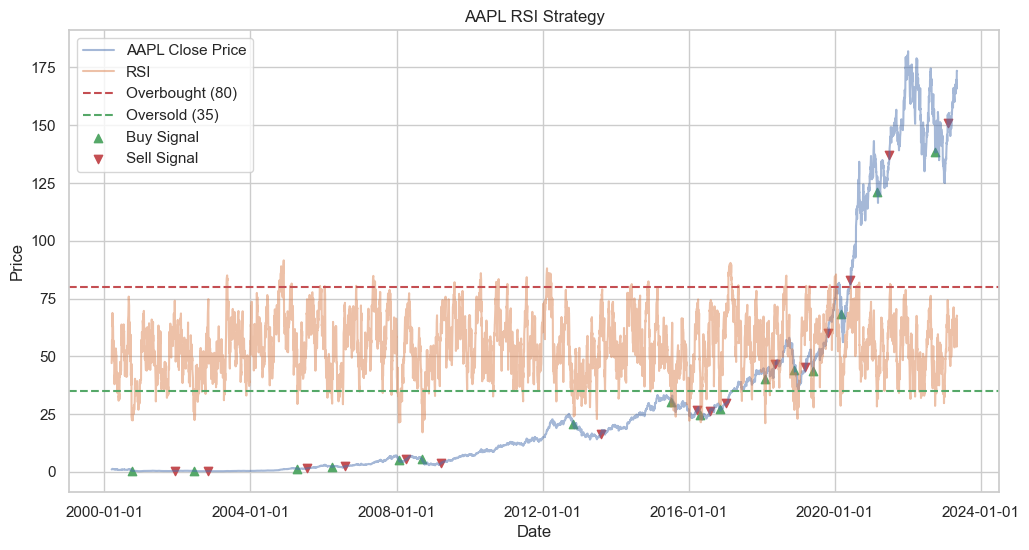

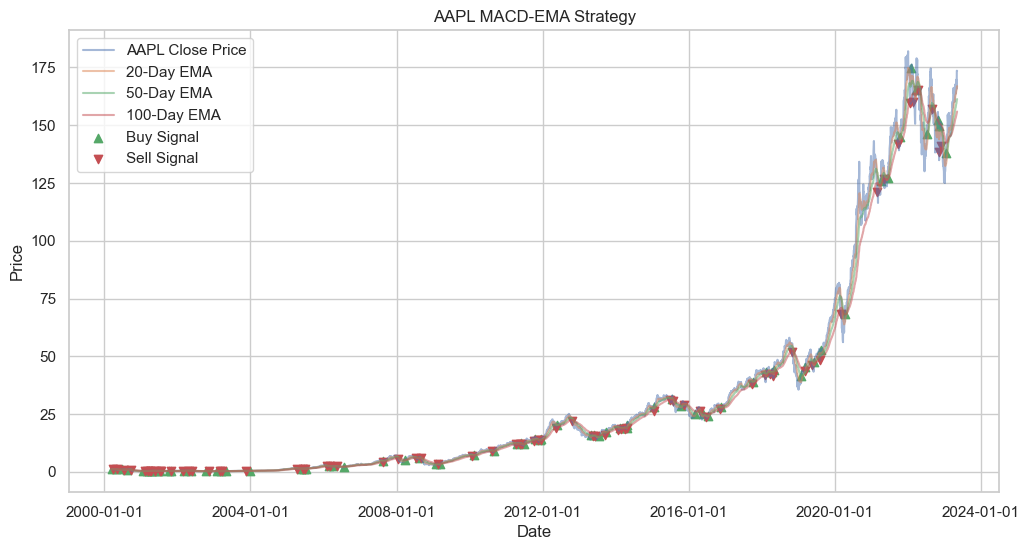

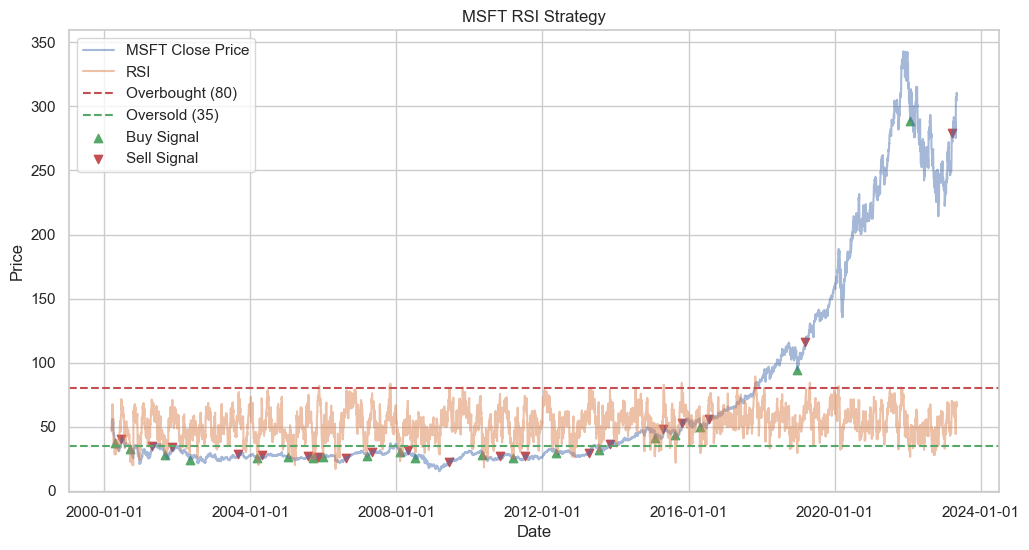

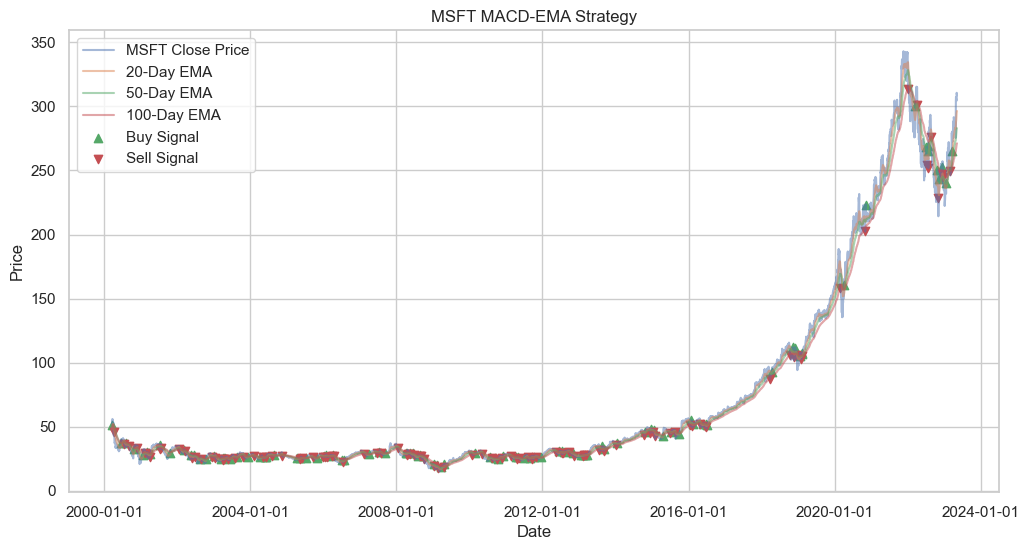

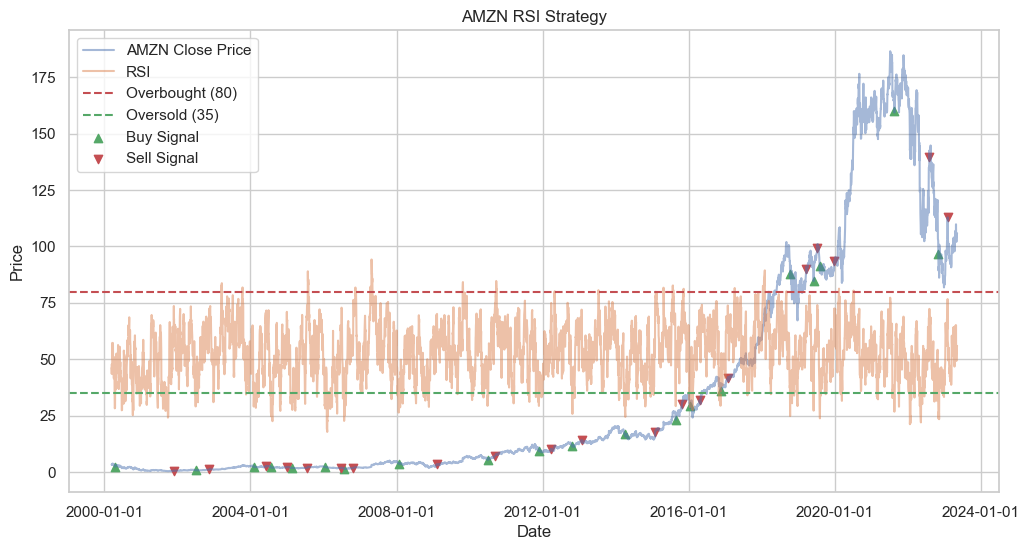

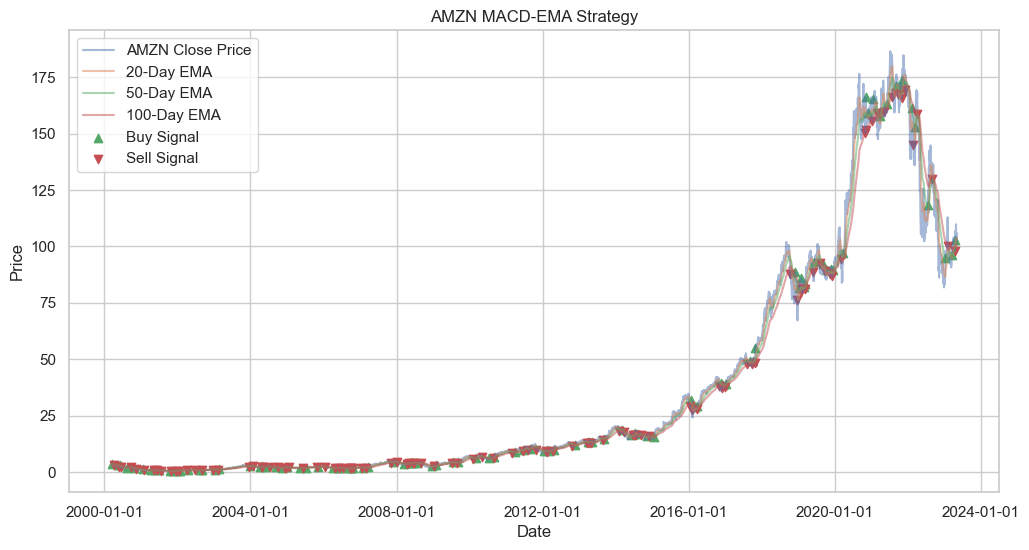

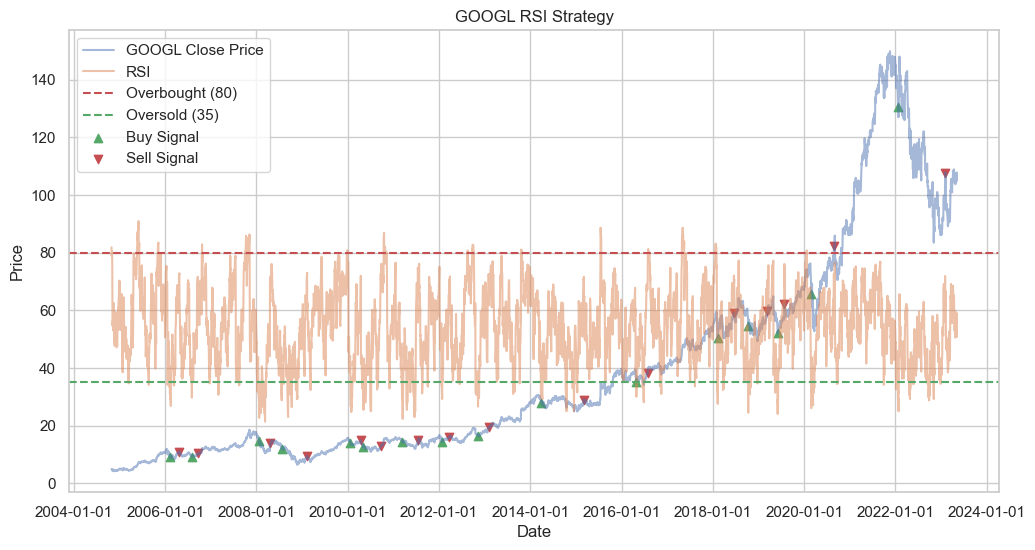

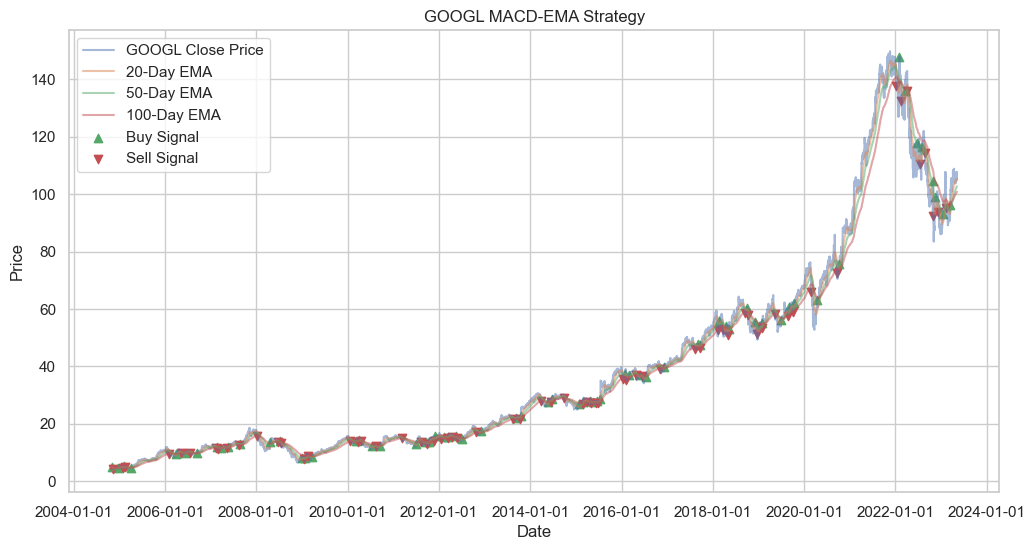

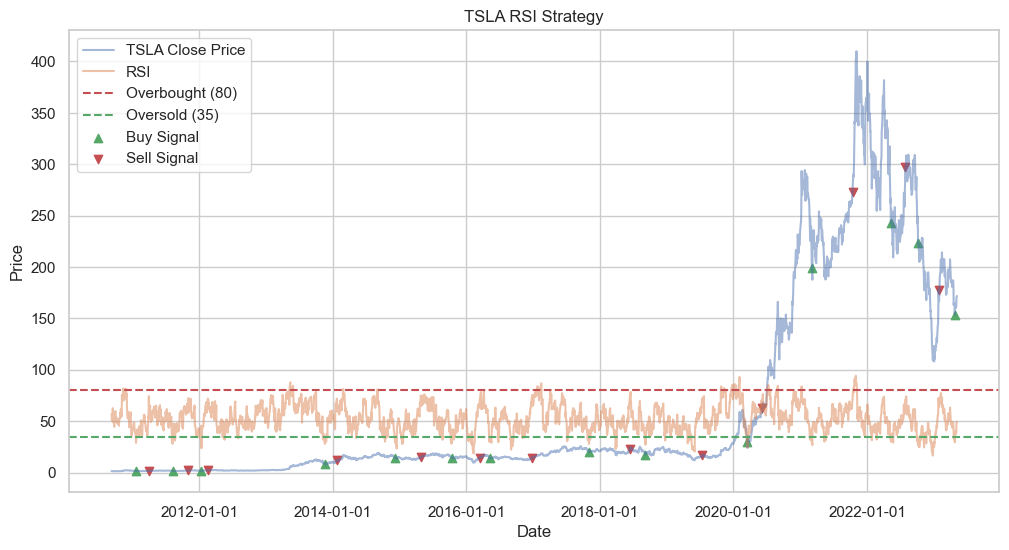

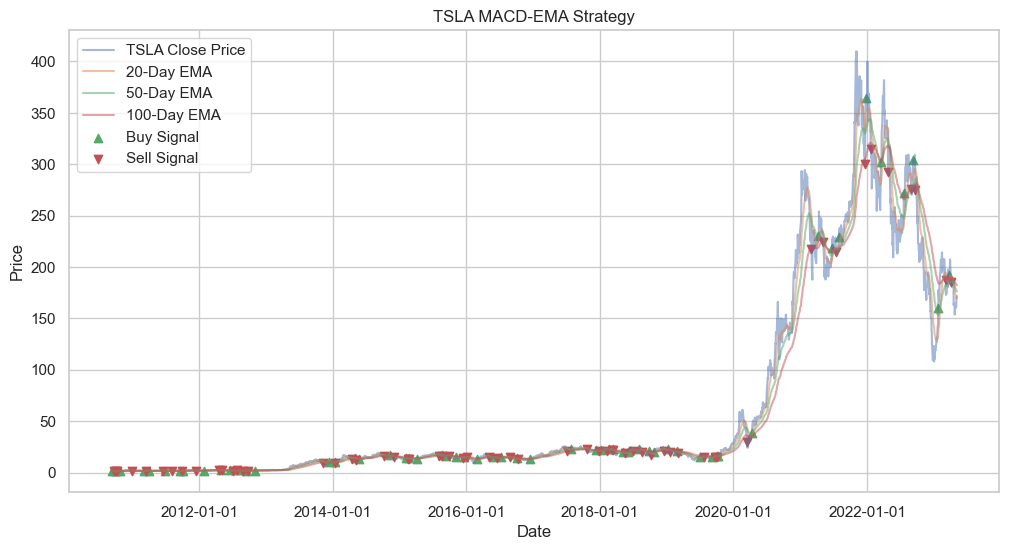

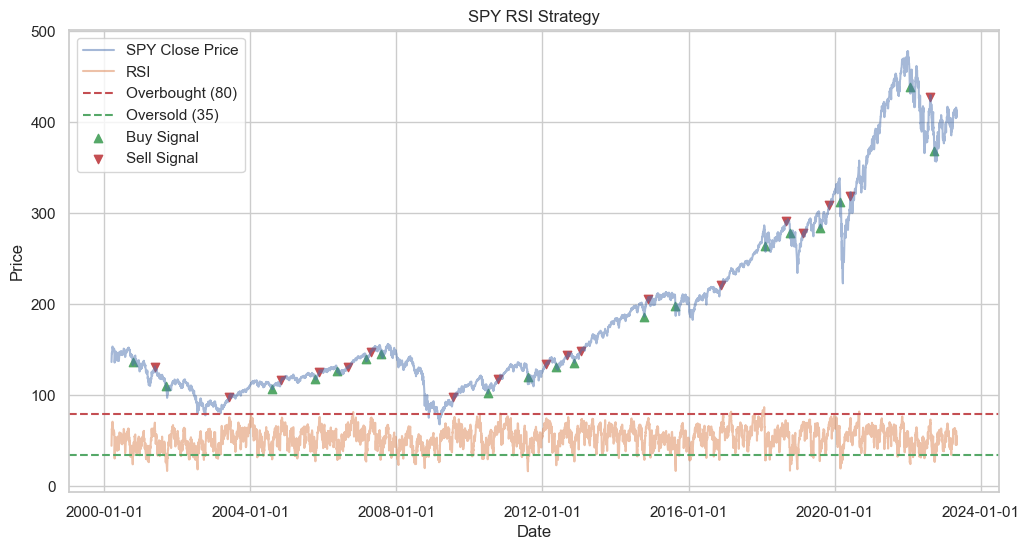

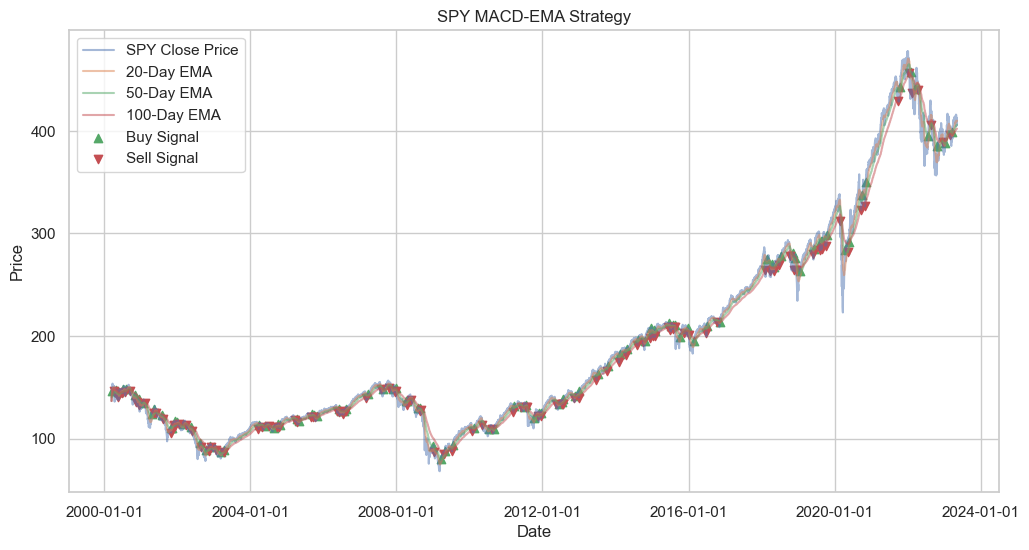

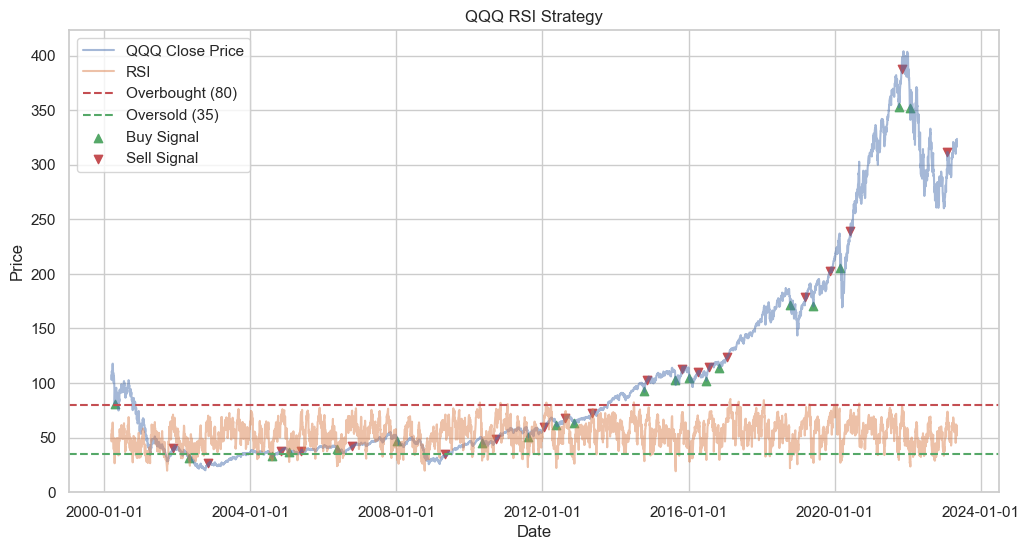

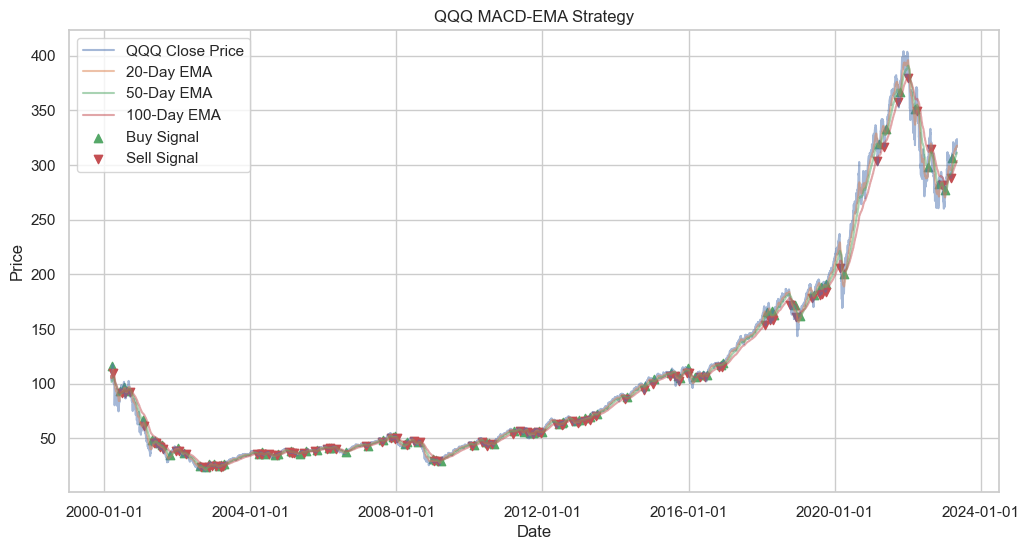

In [21]:
import matplotlib.dates as mdates  # add this import at the beginning

# Define a function to plot the trading signals for a given strategy
def plot_signals(data, ticker, strategy_name, buy_col, sell_col):
    # Create a new figure with a specific size
    plt.figure(figsize=(12, 6))
    # Set the 'Date' column as the index
    data = data.set_index('Date')  
    # Plot the closing price
    plt.plot(data['Close'], label=f"{ticker} Close Price", alpha=0.5)
    
    # Check if the strategy is RSI
    if strategy_name == 'RSI':
        # Set the title of the plot
        plt.title(f"{ticker} RSI Strategy")
        # Plot the RSI
        plt.plot(data['RSI'], label="RSI", alpha=0.5)
        # Add a horizontal line indicating the overbought level
        plt.axhline(y=80, color='r', linestyle='--', label='Overbought (80)')
        # Add a horizontal line indicating the oversold level
        plt.axhline(y=35, color='g', linestyle='--', label='Oversold (35)')
    # Check if the strategy is MACD-EMA
    elif strategy_name == 'MACD_EMA':
        # Set the title of the plot
        plt.title(f"{ticker} MACD-EMA Strategy")
        # Plot the short, medium, and long EMAs
        plt.plot(data['EMA_20'], label="20-Day EMA", alpha=0.5)
        plt.plot(data['EMA_50'], label="50-Day EMA", alpha=0.5)
        plt.plot(data['EMA_100'], label="100-Day EMA", alpha=0.5)

    # Plot the buy signals
    plt.scatter(data.index, data[buy_col], color='g', marker='^', alpha=1, label="Buy Signal")
    # Plot the sell signals
    plt.scatter(data.index, data[sell_col], color='r', marker='v', alpha=1, label="Sell Signal")

    # Add labels and a legend
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='best')
    
    # Set the date format for the x-axis
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    # Save the figure as an image
    plt.savefig(f"{ticker}_{strategy_name}_strategy_2.png")  
    # Display the plot
    plt.show()

# Define a list of stock tickers
stock_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'SPY', 'QQQ']

# Loop over each ticker
for ticker in stock_tickers:
    # Copy the data for the current ticker
    ticker_data = combined_data[combined_data['Ticker'] == ticker].copy()
    # Calculate the buy and sell signals for the RSI and MACD-EMA strategies
    ticker_data['Buy Signals RSI'], ticker_data['Sell Signals RSI'] = rsi_based_trading_strategy(ticker_data)
    ticker_data['Buy Signals MACD_EMA'], ticker_data['Sell Signals MACD_EMA'] = macd_ema_strategy(ticker_data)
    
    # Plot the signals for the RSI strategy
    plot_signals(ticker_data, ticker, 'RSI', 'Buy Signals RSI', 'Sell Signals RSI')
    # Plot the signals for the MACD-EMA strategy
    plot_signals(ticker_data, ticker, 'MACD_EMA', 'Buy Signals MACD_EMA', 'Sell Signals MACD_EMA')

In [22]:
# Get the current date and time
current_datetime = datetime.now()

# Calculate the dates for the 1, 3, and 5-year periods from the most recent date in the data
one_year_ago = current_datetime - timedelta(days=365)  # date one year ago from now
three_years_ago = current_datetime - timedelta(days=365 * 3)  # date three years ago from now
five_years_ago = current_datetime - timedelta(days=365 * 5)  # date five years ago from now

# Filter the DataFrame to get data for the last 1, 3, and 5 years
one_year_data = combined_data[combined_data['Date'] >= one_year_ago]  # data for the last one year
three_years_data = combined_data[combined_data['Date'] >= three_years_ago]  # data for the last three years
five_years_data = combined_data[combined_data['Date'] >= five_years_ago]  # data for the last five years

In [23]:
def calculate_buy_and_hold_returns(data, tickers):
    """
    This function calculates the buy-and-hold returns for the given tickers in the provided DataFrame. 
    The buy-and-hold strategy involves buying a stock and holding it for a certain period of time regardless of market fluctuations.

    Args:
        data (pd.DataFrame): A DataFrame that contains historical stock data with 'Ticker' and 'Adj Close' columns.
        tickers (list): A list of ticker symbols for which the returns should be calculated.
        
    Returns:
        dict: A dictionary where the keys are ticker symbols and the values are dictionaries 
              with 'Total Return' and 'Annualized Return' as percentages.
    """
    buy_and_hold_returns = {}

    for ticker in tickers:
        # Filter the data for the specific ticker
        ticker_data = data[data['Ticker'] == ticker]

        # Get the initial and final adjusted closing prices
        initial_price = ticker_data.iloc[0]['Adj Close']
        final_price = ticker_data.iloc[-1]['Adj Close']

        # Calculate the total percentage return for the buy-and-hold strategy
        total_return_percentage = ((final_price - initial_price) / initial_price) * 100

        # Calculate the number of years in the data
        start_date = ticker_data.iloc[0]['Date']
        end_date = ticker_data.iloc[-1]['Date']
        years = (end_date - start_date).days / 365

        # Calculate the annualized return percentage
        annualized_return_percentage = ((1 + total_return_percentage / 100) ** (1 / years) - 1) * 100

        # Store the results in the dictionary
        buy_and_hold_returns[ticker] = {
            'Total Return': total_return_percentage,
            'Annualized Return': annualized_return_percentage
        }

    return buy_and_hold_returns

tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'SPY', 'QQQ']

# Calculate buy and hold returns for the 1, 3, and 5-year periods
one_year_returns = calculate_buy_and_hold_returns(one_year_data, tickers)
three_years_returns = calculate_buy_and_hold_returns(three_years_data, tickers)
five_years_returns = calculate_buy_and_hold_returns(five_years_data, tickers)

# Print the buy and hold returns
print("Buy and hold returns for the 1-year period:")
for ticker, returns in one_year_returns.items():
    print(f"{ticker}: {returns}")

print("\nBuy and hold returns for the 3-year period:")
for ticker, returns in three_years_returns.items():
    print(f"{ticker}: {returns}")

print("\nBuy and hold returns for the 5-year period:")
for ticker, returns in five_years_returns.items():
    print(f"{ticker}: {returns}")

Buy and hold returns for the 1-year period:
AAPL: {'Total Return': 18.972652655292038, 'Annualized Return': 19.144060617212013}
MSFT: {'Total Return': 19.623092701174862, 'Annualized Return': 19.80085077920757}
AMZN: {'Total Return': 0.4346507382821564, 'Annualized Return': 0.4382606980111614}
GOOGL: {'Total Return': -5.134133690241411, 'Annualized Return': -5.175561286380159}
TSLA: {'Total Return': -29.786107745966113, 'Annualized Return': -29.99157435373516}
SPY: {'Total Return': 6.870231661699151, 'Annualized Return': 6.92909598157192}
QQQ: {'Total Return': 11.76570692586175, 'Annualized Return': 11.868783816150241}

Buy and hold returns for the 3-year period:
AAPL: {'Total Return': 124.08413055947543, 'Annualized Return': 30.955755290651844}
MSFT: {'Total Return': 69.97416987782059, 'Annualized Return': 19.40026288635086}
AMZN: {'Total Return': -12.137812775096842, 'Annualized Return': -4.233002095158889}
GOOGL: {'Total Return': 53.56336481541092, 'Annualized Return': 15.4161189206

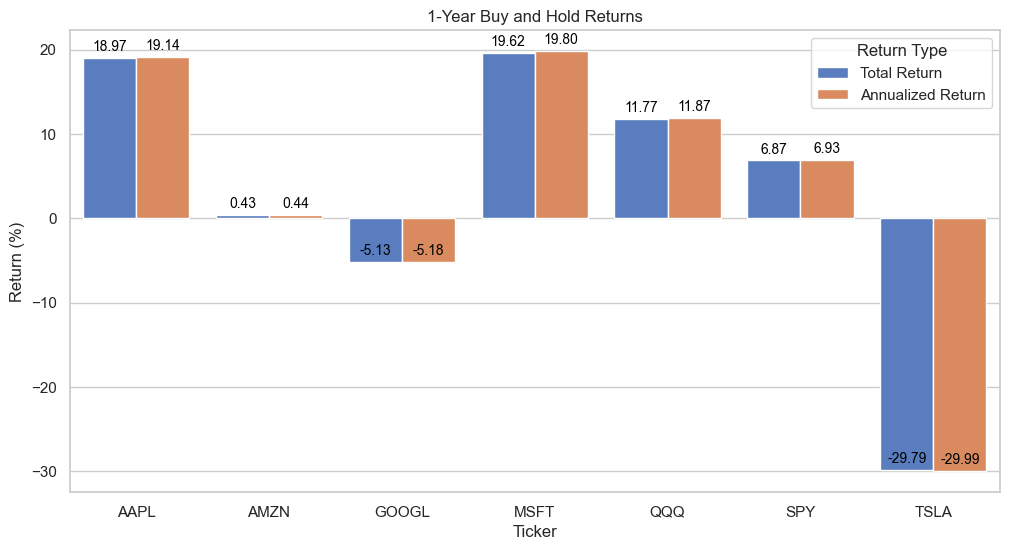

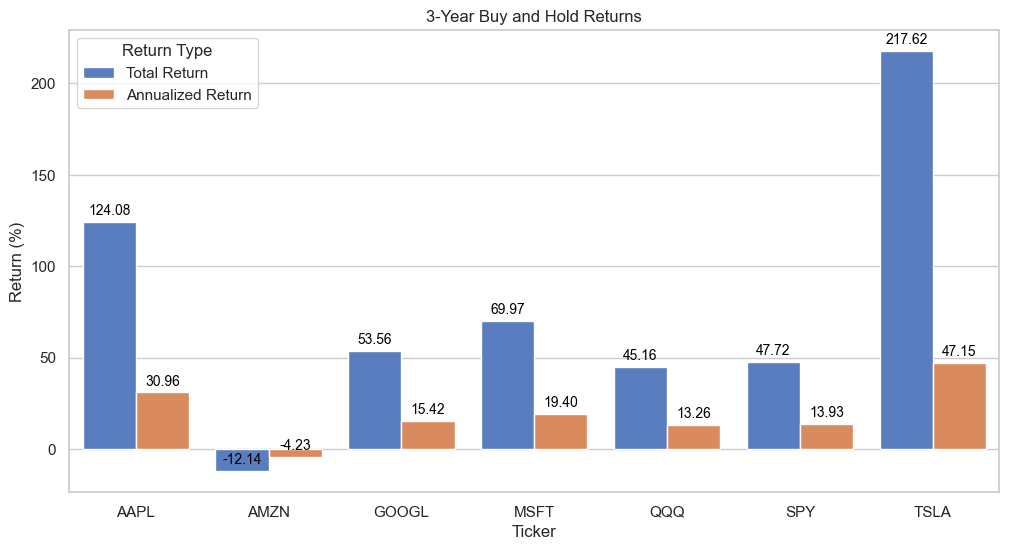

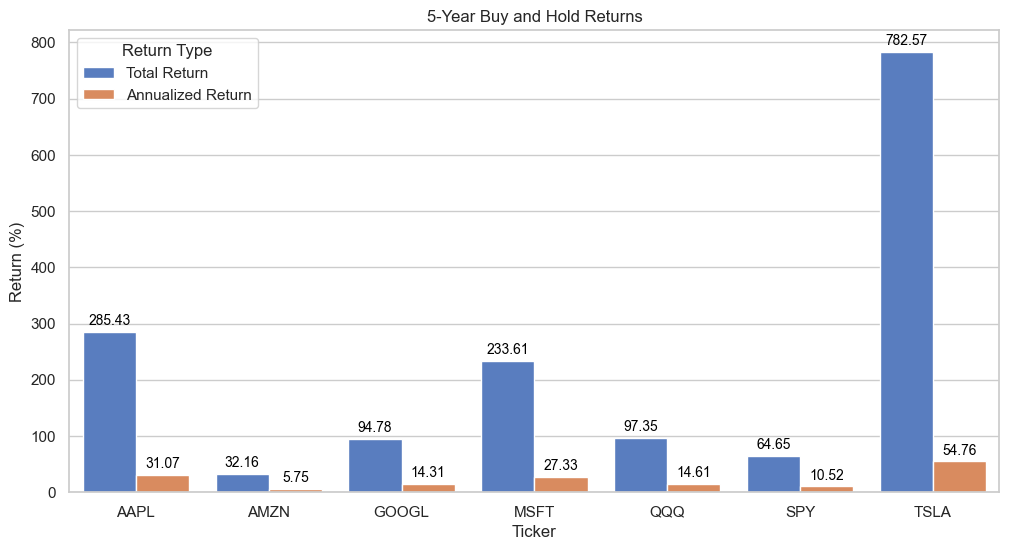

In [19]:
def plot_bar_chart(returns, title):
    """
    This function plots a bar chart for the given returns data and title.
    
    Args:
        returns (dict): A dictionary containing total and annualized returns for each ticker.
        title (str): The title for the bar chart.
    """
    # Convert the returns data into a pandas DataFrame
    tickers = list(returns.keys())
    total_returns = [ret['Total Return'] for ret in returns.values()]
    annualized_returns = [ret['Annualized Return'] for ret in returns.values()]

    data = pd.DataFrame({'Ticker': tickers,
                         'Total Return': total_returns,
                         'Annualized Return': annualized_returns})

    # Melt the data to create a long format DataFrame suitable for seaborn
    data = data.melt(id_vars='Ticker', var_name='Return Type', value_name='Return (%)')
    data.sort_values(by='Ticker', inplace=True)

    # Set up the figure and the bar chart using seaborn
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    chart = sns.barplot(data=data, x='Ticker', y='Return (%)', hue='Return Type', palette="muted")
    chart.set_title(title)

    # Annotate the bars with their values for easy reading
    for p in chart.patches:
        chart.annotate(
            f'{p.get_height():.2f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='baseline',
            fontsize=10, color='black',
            xytext=(0, 5),
            textcoords='offset points'
        )

    # Save the chart as a PNG image
    plt.savefig(f"{title.replace(' ', '_')}.png")

    # Display the chart
    plt.show()

# Plot the bar charts for 1-year, 3-year, and 5-year buy and hold returns
plot_bar_chart(one_year_returns, '1-Year Buy and Hold Returns')
plot_bar_chart(three_years_returns, '3-Year Buy and Hold Returns')
plot_bar_chart(five_years_returns, '5-Year Buy and Hold Returns')